In [1]:
%cd ..

/Users/pablomirallesgonzalez/Documents/masters-degree/Análisis de Redes Sociales/sna-ceb-assignment


In [2]:
import sys
sys.path.append('src')

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import functools
import random

from networkx import community as nxcom
from cdlib import NodeClustering
from cdlib.evaluation import avg_odf, flake_odf, internal_edge_density, normalized_mutual_information

from genetic_algs import NSGA2, tournament_select, random_locus_crossover, mutate_locus, create_locus
from disjoint_set_union import DisjointSetUnion

In [4]:
def community_list_to_dict(communities: list[list[int]]) -> dict[int, int]:
    # list of list of nodes in the same community to dict of node to community
    return {
        node: ind
        for ind, community in enumerate(communities)
        for node in community
    }

def community_dict_to_list(community_dict: dict[int, int]) -> list[list[int]]:
    # dict of node to community to list of list of nodes in the same community
    num_communities = max(community_dict.values()) + 1
    communities = [[] for _ in range(num_communities)]
    for node, community in community_dict.items():
        communities[community].append(node)
    return communities

## Carga de datos

Leemos el grafo, y preparamos unas estructuras de datos para pasar de etiquetas a índices, es decir, que el nodo i-ésimo se pueda identificar con el índice $i$ y con su etiqueta (e.g. `"1234"`) fácilmente.

In [5]:
GRAPH_FILE = "data/amazon_graph.graphml"
graph = nx.read_graphml(GRAPH_FILE)

In [6]:
nodes = list(graph.nodes())
node_to_idx = {node: idx for idx, node in enumerate(nodes)}
idx_to_node = {idx: node for idx, node in enumerate(nodes)}

edges: list[list[int]] = [
    [ node_to_idx[neighbour] for neighbour in graph.neighbors(idx_to_node[idx]) ]
    for idx in range(graph.number_of_nodes())
]

Respecto a las métricas, usaré la modularidad y otra que esté correlacionada negativamente. En particular, para la última probaré con la densidad y la fracción media de 

In [19]:
# unify metrics interface, so we can pass this as parameters
modularity_metric = lambda communities: nxcom.modularity(graph, communities)
internal_density_metric = lambda communities: internal_edge_density(graph, NodeClustering(communities, graph)).score
flake_odf_metric = lambda communities: 1. - flake_odf(graph, NodeClustering(communities, graph)).score

In [22]:
BUDGET_FITNESS_CALLS = 5_000

def evaluate(
    population_size: int,
    pcross: float,
    pmut: float,
    mutate_ratio: float,
    T: int,
    metric_1: callable,
    metric_2: callable,
):
    ngen = BUDGET_FITNESS_CALLS // population_size
    mutate_fn = functools.partial(mutate_locus, edges, mutate_ratio)
    select_fn = functools.partial(tournament_select, T)

    def fitness_fn(individual: list[int]) -> tuple[float, float]:
        # calculate components using disjoint set union
        dsu = DisjointSetUnion(len(individual))
        for i1, i2 in enumerate(individual):
            dsu.join(i1, i2)
        components = dsu.get_components()
        communities = [[idx_to_node[idx] for idx in component] for component in components]
        
        return metric_1(communities), metric_2(communities)

    population = create_locus(edges, population_size)

    ga = NSGA2[list[int], tuple[float, float]](
        fitness_fn=fitness_fn,
        select_fn=select_fn,
        crossover_fn=random_locus_crossover,
        mutate_fn=mutate_fn,
        pcross=pcross,
        pmut=pmut,
    )

    population_with_fitness = ga.run(population, ngen=ngen, trace=25)

    return population_with_fitness

In [23]:
%prun -s cumulative population_with_fitness = evaluate(50, 0.8, 0.3, 0.2, 8, modularity_metric, internal_density_metric)

Generation 0 - std_dev_fitness=[0.03009797610754305, 0.03459934447988493]
		Best value for objective 0: (0.7392927661614316, 0.5629841864658367)
		Best value for objective 1: (0.6411999520635501, 0.6590325920629662)
Generation 25 - std_dev_fitness=[0.02624799828985191, 0.026575339017798086]
		Best value for objective 0: (0.7824209476579623, 0.5826695555280538)
		Best value for objective 1: (0.6974650035381667, 0.7029835012610801)
Generation 50 - std_dev_fitness=[0.030076481717950618, 0.024493013897170096]
		Best value for objective 0: (0.7897601465485755, 0.6235050035683274)
		Best value for objective 1: (0.7128499646183344, 0.708301275807104)
Generation 75 - std_dev_fitness=[0.027070421956703603, 0.02362818478488679]
		Best value for objective 0: (0.7897601465485755, 0.6235050035683274)
		Best value for objective 1: (0.7128499646183344, 0.708301275807104)
Generation 99 - std_dev_fitness=[0.03162656038084096, 0.021767518372895485]
		Best value for objective 0: (0.8087053877145725, 0.61

         235822248 function calls (217093660 primitive calls) in 117.967 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  118.715  118.715 {built-in method builtins.exec}
        1    0.000    0.000  118.715  118.715 <string>:1(<module>)
        1    0.000    0.000  118.715  118.715 806022718.py:3(evaluate)
        1    0.009    0.009  118.666  118.666 genetic_algs.py:44(run)
      101    0.109    0.001  103.482    1.025 genetic_algs.py:81(__calc_fitness)
     5050    0.772    0.000  103.374    0.020 806022718.py:16(fitness_fn)
5996012/3005596    7.736    0.000   73.228    0.000 {built-in method builtins.sum}
     5050    0.035    0.000   63.041    0.012 978221323.py:3(<lambda>)
     5050    1.490    0.000   62.578    0.012 fitness.py:319(internal_edge_density)
5183195/1300230    1.884    0.000   50.589    0.000 {built-in method builtins.len}
   295833    0.427    0.000   46.970    0.000 report

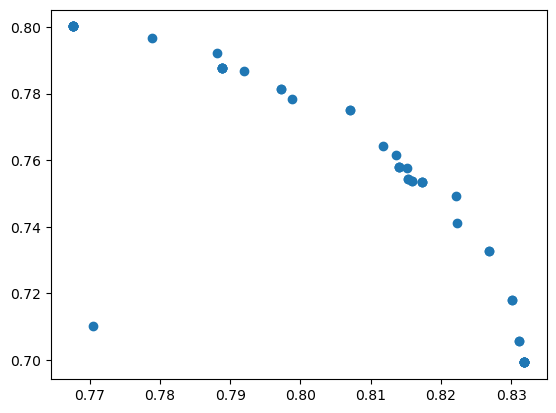

In [19]:
# plot pareto front
fitness_values = np.array([fitness for fitness, _ in population_with_fitness])
plt.scatter(fitness_values[:, 0], fitness_values[:, 1])